In [1]:
cd / home / soda / rcappuzz / work / benchmark - join - suggestions

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.colors as mcolors
import src.utils.plotting as plotting
from src.utils.logging import read_logs
import tarfile
import json
import pandas as pd 

In [4]:
cfg = pl.Config()
cfg.set_fmt_str_lengths(150)

polars.config.Config

In [5]:
def pivot_based_on_value(melted_df, variable):
    pivoted = (
        melted_df.filter(pl.col("variable") == variable)
        .to_pandas()
        .pivot_table(
            values="value",
            index=["base_table", "chosen_model"],
            columns=["estimator", "variable"],
            aggfunc="mean",
        )
    )
    display(
        pivoted.style.background_gradient(axis=1, cmap="RdYlGn").format(precision=3)
    )

In [13]:
def melt_table(df):
    melted = df.melt(
        id_vars=["base_table", "estimator", "chosen_model", "jd_method"],
        value_vars=["r2score", "n_cols", "time_fit", "time_predict", "time_run"],
    )
    return melted

In [14]:
run_path = "results/logs/0264-8yksy58g"
df_results = read_logs(exp_name=None, exp_path=run_path)

In [15]:
melted_df = melt_table(df_results)

In [116]:
variable = "r2score"
pivoted = (
    melted_df.filter(pl.col("variable") == variable)
    .to_pandas()
    .pivot_table(
        values="value",
        index=["base_table", "jd_method", "chosen_model"],
        columns=["estimator", "variable"],
        aggfunc="mean",
    )
)
display(
    pivoted.style.background_gradient(axis=1, cmap="RdYlGn").format(precision=3)
)

In [20]:
pivoted.style.background_gradient(axis=1, cmap="RdYlGn").format(precision=3).to_html(
    "test_table.html"
)

In [27]:
melted_df.filter(
    (pl.col("chosen_model") == "catboost") & (pl.col("variable") == "r2score")
)

base_table,estimator,chosen_model,jd_method,variable,value
str,str,str,str,str,f64
"""us-elections-yadl""","""nojoin""","""catboost""","""minhash""","""r2score""",0.726341
"""us-elections-yadl""","""stepwise_greedy_join""","""catboost""","""minhash""","""r2score""",0.744118
"""us-elections-yadl""","""highest_containment""","""catboost""","""minhash""","""r2score""",0.747679
"""us-elections-yadl""","""best_single_join""","""catboost""","""minhash""","""r2score""",0.743693
"""us-elections-yadl""","""full_join""","""catboost""","""minhash""","""r2score""",0.743219
"""us-elections-yadl""","""nojoin""","""catboost""","""minhash""","""r2score""",0.742399
"""us-elections-yadl""","""stepwise_greedy_join""","""catboost""","""minhash""","""r2score""",0.728286
"""us-elections-yadl""","""highest_containment""","""catboost""","""minhash""","""r2score""",0.730379
"""us-elections-yadl""","""best_single_join""","""catboost""","""minhash""","""r2score""",0.746341


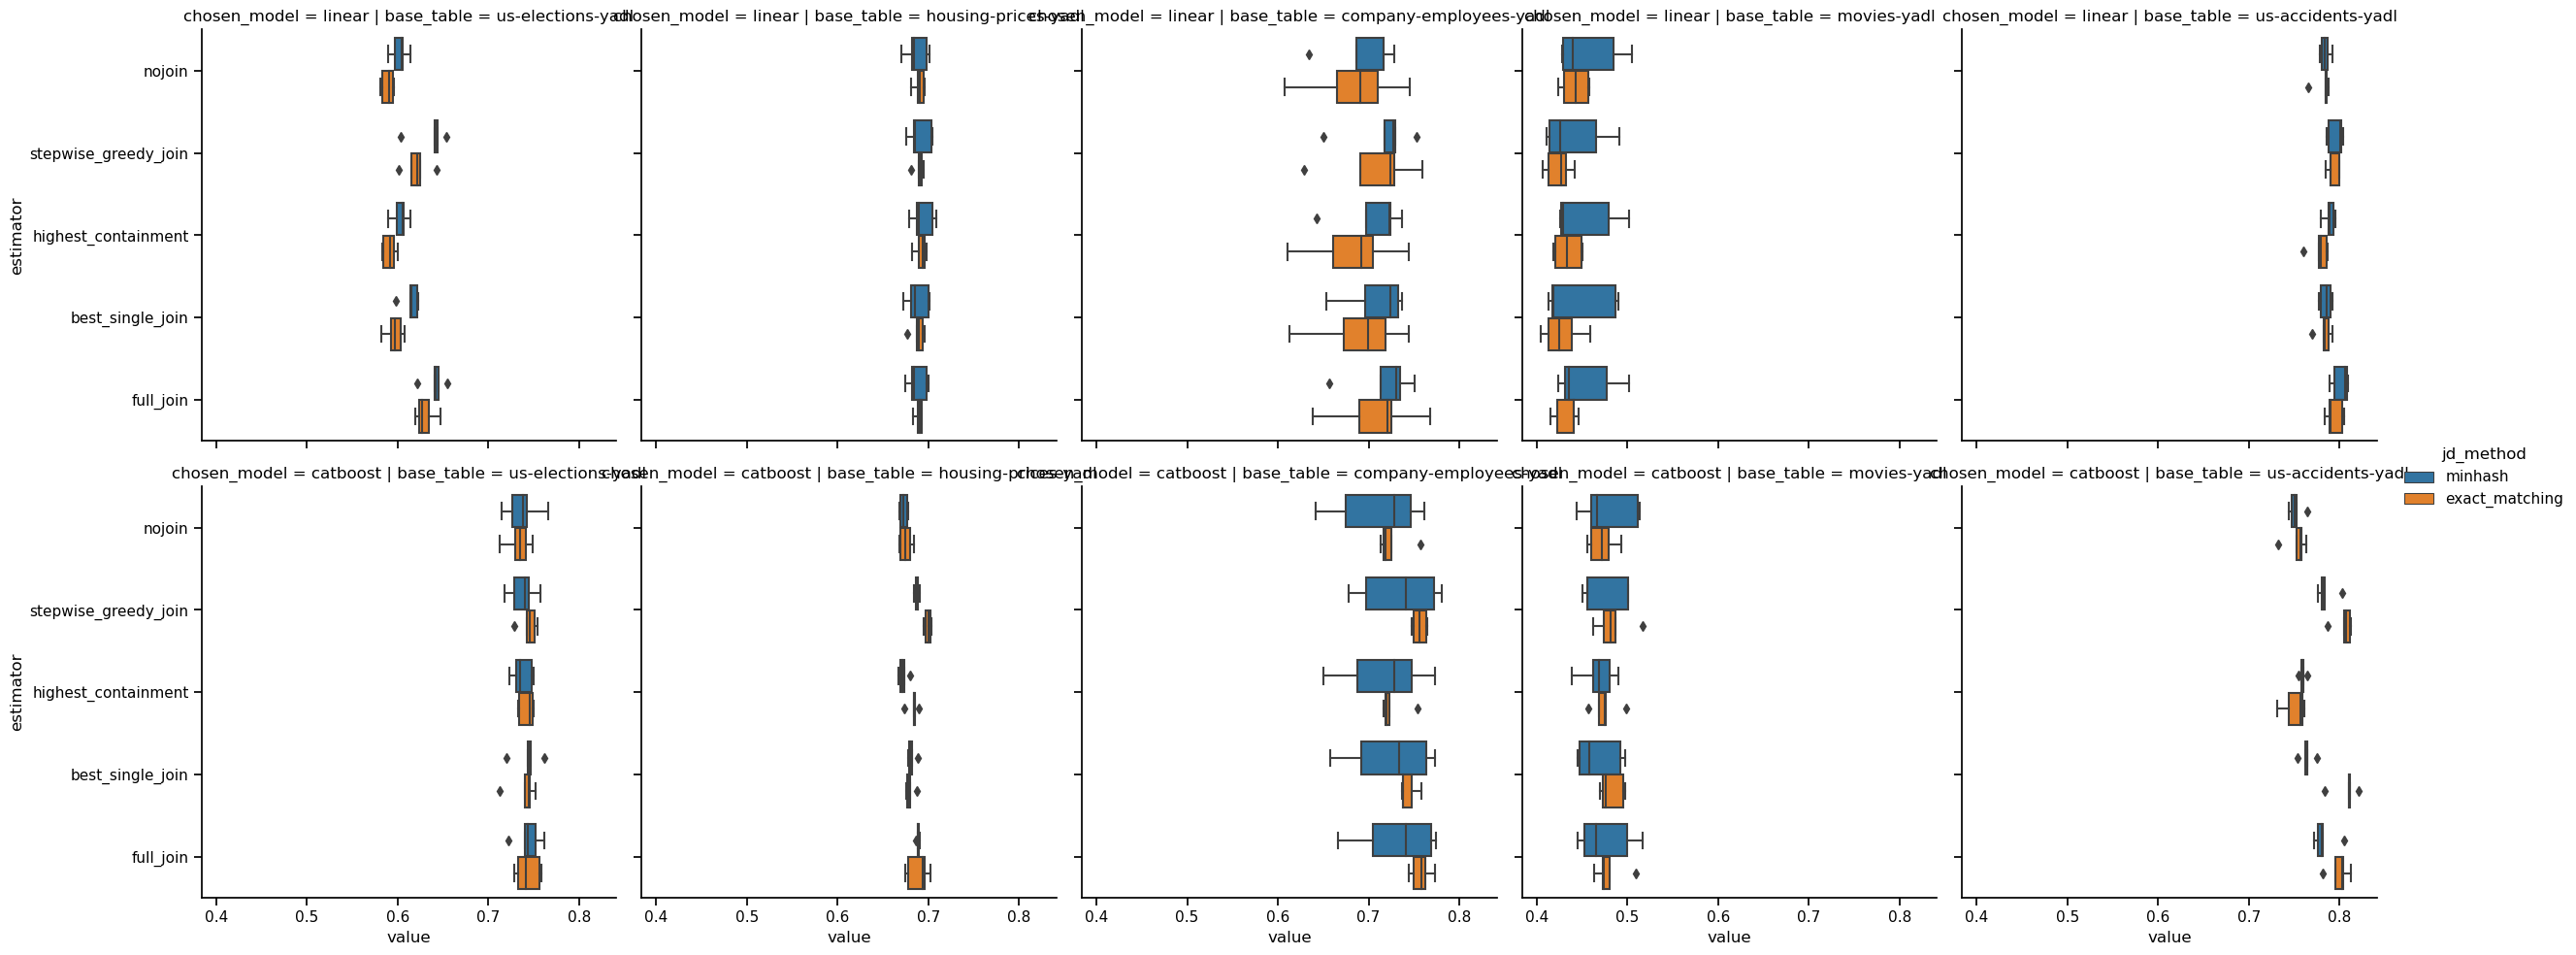

In [42]:
sns.set_context("notebook")
sns.catplot(
    data=melted_df.filter(
        # (pl.col("chosen_model") == "catboost") &
        (pl.col("variable") == "r2score")
    ).to_pandas(),
    x="value",
    y="estimator",
    col="base_table",
    row="chosen_model",
    hue="jd_method",
    kind="box",
    # sharex=False
)

In [47]:
pth_qr1 = Path(
    "results/query_results/binary_update__exact_matching__us-elections-yadl__col_to_embed.pickle"
)
pth_qr2 = Path(
    "results/query_results/binary_update__minhash__us-elections-yadl__col_to_embed.pickle"
)

In [48]:
from joblib import load

In [75]:
targets = []
for tname in [
    "housing-prices-yadl",
    "us-accidents-yadl",
    "company-employees-yadl",
    "movies-yadl",
    "us-elections-yadl",
]:
    df = pl.read_parquet(f"data/source_tables/{tname}.parquet")
    targets.append(
        df.with_columns(pl.lit(tname).alias("table_name")).select(
            pl.col("target", "table_name")
        )
    )

In [76]:
concat = pl.concat(targets)

<Axes: xlabel='Proportion', ylabel='target'>

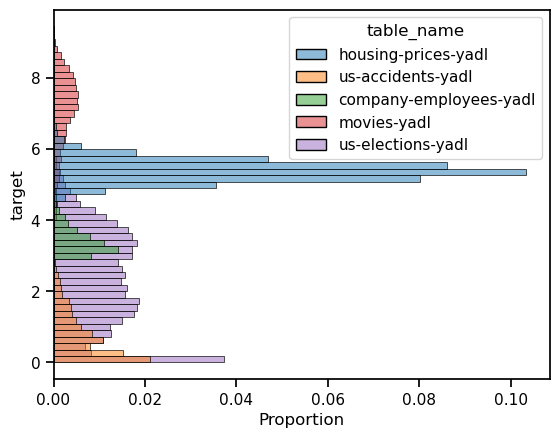

In [81]:
sns.histplot(concat, y="target", hue="table_name", stat="proportion")

In [97]:
df_ = (
    df_results.select("jd_method", "base_table", "estimator", "chosen_model", "r2score")
    .group_by(["jd_method", "base_table", "chosen_model", "estimator"])
    .agg(pl.mean("r2score"))
)

In [98]:
df_

jd_method,base_table,chosen_model,estimator,r2score
str,str,str,str,f64
"""exact_matching""","""us-elections-yadl""","""linear""","""best_single_join""",0.596638
"""exact_matching""","""us-accidents-yadl""","""linear""","""highest_containment""",0.777675
"""minhash""","""us-elections-yadl""","""linear""","""stepwise_greedy_join""",0.636734
"""exact_matching""","""us-accidents-yadl""","""linear""","""nojoin""",0.781552
"""exact_matching""","""housing-prices-yadl""","""linear""","""full_join""",0.689318
"""exact_matching""","""company-employees-yadl""","""linear""","""full_join""",0.708365
"""minhash""","""movies-yadl""","""linear""","""nojoin""",0.457231
"""minhash""","""us-elections-yadl""","""catboost""","""stepwise_greedy_join""",0.737881
"""minhash""","""movies-yadl""","""catboost""","""highest_containment""",0.468179


In [107]:
joined = df_.join(
    df_.filter(pl.col("estimator") == "nojoin").drop("estimator"),
    on=["jd_method", "base_table", "chosen_model"],
    how="left",
).sort(["jd_method", "base_table", "chosen_model"]).with_columns((pl.col("r2score") - pl.col("r2score_right")).alias("difference"))

In [108]:
joined

jd_method,base_table,chosen_model,estimator,r2score,r2score_right,difference
str,str,str,str,f64,f64,f64
"""exact_matching""","""company-employees-yadl""","""catboost""","""best_single_join""",0.743828,0.726058,0.01777
"""exact_matching""","""company-employees-yadl""","""catboost""","""full_join""",0.757722,0.726058,0.031664
"""exact_matching""","""company-employees-yadl""","""catboost""","""nojoin""",0.726058,0.726058,0.0
"""exact_matching""","""company-employees-yadl""","""catboost""","""highest_containment""",0.726284,0.726058,0.000226
"""exact_matching""","""company-employees-yadl""","""catboost""","""stepwise_greedy_join""",0.756026,0.726058,0.029969
"""exact_matching""","""company-employees-yadl""","""linear""","""full_join""",0.708365,0.683744,0.024621
"""exact_matching""","""company-employees-yadl""","""linear""","""best_single_join""",0.689584,0.683744,0.00584
"""exact_matching""","""company-employees-yadl""","""linear""","""stepwise_greedy_join""",0.706094,0.683744,0.02235
"""exact_matching""","""company-employees-yadl""","""linear""","""highest_containment""",0.682548,0.683744,-0.001196


In [106]:
v_std = concat.group_by("table_name").agg(pl.std("target"))

In [110]:
_dd=joined.join(v_std, left_on="base_table", right_on="table_name")

<Axes: xlabel='target', ylabel='difference'>

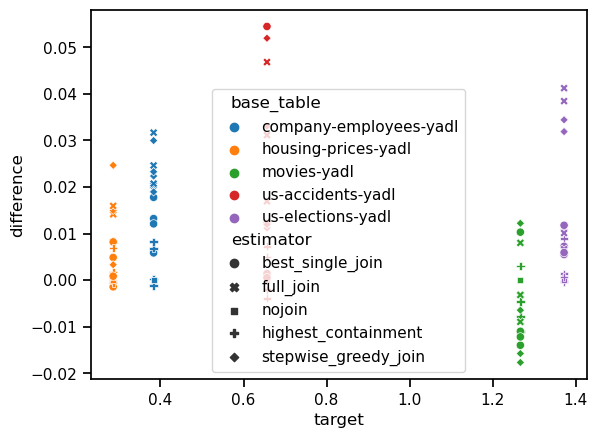

In [114]:
sns.scatterplot(data=_dd, x="target", y="difference", hue="base_table", style="estimator")

## Measure overlap

In [128]:
ls_overlap = []
for tname in [
    "housing-prices-yadl",
    "us-accidents-yadl",
    "company-employees-yadl",
    "movies-yadl",
    "us-elections-yadl",
]:
    bpath = Path(f"results/query_results/binary_update__exact_matching__{tname}__col_to_embed.pickle")
    qr = load(bpath)
    sim = [cj.similarity_score for cj in qr.candidates.values()]
    avg_sim = sum(sim)/qr.n_candidates
    ls_overlap.append({"table_name":tname, "avg_sim":avg_sim})

In [130]:
df_overlap = pl.from_dicts(ls_overlap)

In [131]:
df_overlap

table_name,avg_sim
str,f64
"""housing-prices-yadl""",0.272927
"""us-accidents-yadl""",0.371912
"""company-employees-yadl""",0.082218
"""movies-yadl""",0.080115
"""us-elections-yadl""",0.257545


In [139]:
_dd=joined.join(df_overlap, left_on="base_table", right_on="table_name")

In [140]:
_dd = _dd.filter(pl.col("estimator") != "nojoin")

<Axes: xlabel='avg_sim', ylabel='difference'>

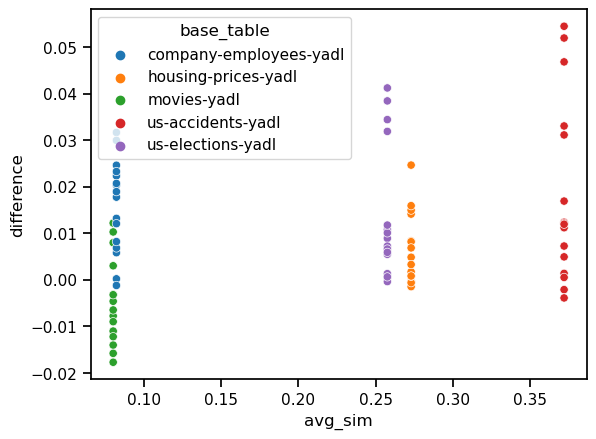

In [147]:
sns.scatterplot(data=_dd.to_pandas(), x="avg_sim", y="difference", hue="base_table")

In [144]:
df_overlap

table_name,avg_sim
str,f64
"""housing-prices-yadl""",0.272927
"""us-accidents-yadl""",0.371912
"""company-employees-yadl""",0.082218
"""movies-yadl""",0.080115
"""us-elections-yadl""",0.257545
